In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

p = 1000
n = 70


In [99]:
def solve_max_margin(X):
    n, p = X.shape
    w_max_margin = cp.Variable(p)
    objective = cp.Minimize(cp.sum_squares(w_max_margin))
    constraints = [np.linalg.norm(X)**2/n <= x @ w_max_margin for x in X]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    primal_val = w_max_margin.value
    dual_vals = np.array([constraint.dual_value for constraint in constraints])
#     print(prob.status)
    return {
        'X': np.copy(X),
        'w': primal_val,
        'dual': dual_vals,
        'number of support vectors': np.sum(np.array(dual_vals) < 1e-10),
        'status': prob.status
    }



In [100]:
mu = np.random.randn(p)
results = []
mu_scale_range = np.logspace(0, 2, 50)
Sigma = 1 / np.arange(1, p + 1)
Q =  np.random.randn(n, p) *  np.sqrt(Sigma)
for mu_scale in mu_scale_range:
    X = Q + mu * mu_scale
    results += [solve_max_margin(X)]

    

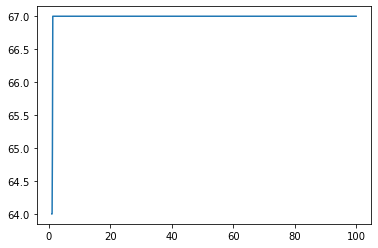

In [101]:

plt.plot(mu_scale_range, [res['number of support vectors'] for res in results])

In [123]:
def evaluate(w, Sigma, mu):
    return mu @ w / np.linalg.norm(w * np.sqrt(Sigma))
k = 15
Sigma = 1 / np.arange(1, p + 1)**3
# Sigma = np.ones(p)
# Sigma[:k] *= 30
mu = np.sign(np.random.randn(p)) * (Sigma**(3))
mu = np.random.randn(p)
# mu[:k] *= np.arange(1, k+1)**2
mu[k:] *= 0
results = []
mu_scale_range = np.logspace(-4, 2, 3)

Q =  np.random.randn(n, p) *  np.sqrt(Sigma)
for mu_scale in mu_scale_range:
    X = Q + mu * mu_scale
    results += [{
        'max marg': solve_max_margin(X)['w'],
        'mni': np.linalg.pinv(X) @ np.ones(n),
        'mean': X.T @ np.ones(n)/n,
        'mu': mu,
        'mu perp':  mu - np.linalg.pinv(Q) @ Q @ mu,
        'opt': mu/Sigma
    }]
lambda_star = np.linalg.svd(Q)[1][-1]**2/n

SNR = (mu @ (mu * (1/Sigma + 1/lambda_star))) / np.sqrt(mu @ (mu * Sigma / (Sigma**2 + lambda_star**2)))
print("SNR = ", SNR)  

SNR =  259980.50203800166


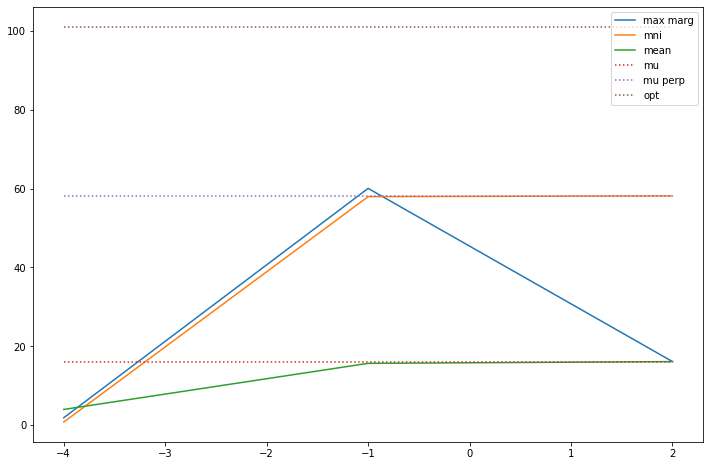

In [124]:
plt.figure(figsize=(12, 8))
for label in ['max marg-', 'mni-', 'mean-', 'mu:', 'mu perp:', 'opt:']:
    plt.plot(np.log(mu_scale_range)/np.log(10), [evaluate(res[label[:-1]], Sigma, mu) for res in results], label[-1], label=label[:-1], )
plt.legend()
    

mu 26.39818386742273
mu perp 28.549938237037168
opt 31.392674304684522


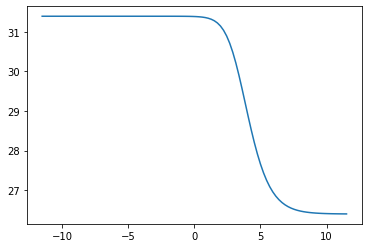

In [192]:
slanted_mu_perfs = []
c_range = np.logspace(-5, 5, 100)
for c in c_range:
    slanted_mu_perfs += [evaluate(mu/(Sigma + c), Sigma, mu)]
plt.plot(np.log(c_range), slanted_mu_perfs)
estimators = {        
    'mu': mu,
    'mu perp':  mu - np.linalg.pinv(Q) @ Q @ mu,
    'opt': mu/Sigma
    }
for est_name in estimators:    
    print(est_name, evaluate(estimators[est_name], Sigma, mu))

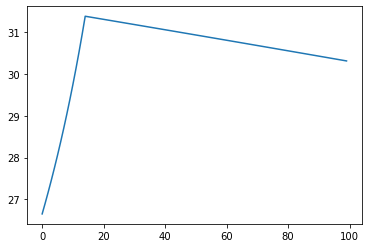

In [199]:
mu_current = np.copy(mu)
mu_partially_slanted_perfs = []
mni_overlaps = []
s = 1#np.linalg.svd(Q)[1][-1]**2/n
for i in range(p):
    mu_current[i] /= s * Sigma[i]
    mu_partially_slanted_perfs += [evaluate(mu_current, Sigma, mu)]
    mni_overlaps += [(mu_current @ estimators['mu perp']) /np.linalg.norm(mu_current) / np.linalg.norm(estimators['mu perp'])]
plt.plot(mu_partially_slanted_perfs[:100])

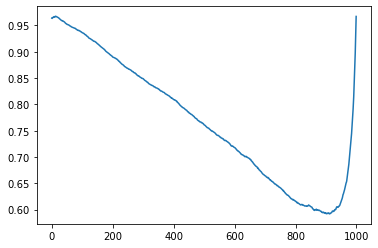

In [194]:
plt.plot(mni_overlaps)

In [173]:
s, Sigma[60], np.sum(Sigma[60:])/n

(0.025613677282824158, 0.01639344262295082, 0.040080006394265816)

In [163]:
evaluate(mu, Sigma, mu)

321.54290193769094

In [168]:
np.linalg.norm(mu_current) * np.linalg.norm(estimators['mu perp']) /(mu_current @ estimators['mu perp'])

1.1500518047517354

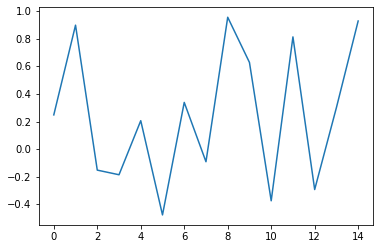

In [198]:
k = -1
k = 15
plt.plot((estimators['mu perp']/mu)[:k])# * Sigma[:k])

556.0533151271587

In [202]:
lambda_star

8.478240806322763

# Projectng on a simplex

In [2]:
# we are projecting a random vector on a standard simplex
n = 100
mu = np.random.randn(n)

def project_on_a_standard_simplex(mu):
    n = len(mu)
    p = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(mu - p))
    constraints = [p >= 0, cp.sum(p) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return p.value
def project_on_sum_one(mu):
    n = len(mu)
    return mu - np.ones(n) * np.sum(mu)/n + np.ones(n) / n


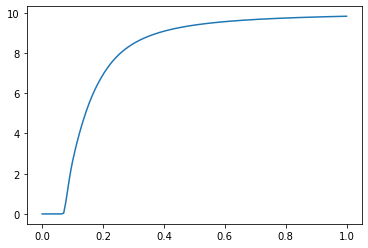

In [3]:
mu_scale_range = np.logspace(-5, 2, 50)
mu_scale_range = np.linspace(1e-8, 1, 1000)
results = []
for mu_scale in mu_scale_range:
    results += [np.linalg.norm(project_on_sum_one(mu * mu_scale) - project_on_a_standard_simplex(mu * mu_scale))/(mu_scale)]
plt.plot(mu_scale_range**0.5, results)

In [20]:
def project_on_data_simplex(mu, Q):
    n, d = Q.shape
    p = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(mu - Q.T @ p))
    constraints = [p >= 0, cp.sum(p) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return Q.T @ p.value

def project_on_data_simplex_preprocessed(
    mu_inner_coord, #coordinates of mu_parallel in the span of Q
    A
):
    n = len(mu_inner_coord)
    p = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(mu_inner_coord - p, A))
    constraints = [p >= 0, cp.sum(p) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return p.value


In [12]:
#TODO fix this
def project_on_data_span(mu, Q):
    n, d = Q.shape
    mni_null = np.linalg.pinv(Q) @ np.ones(n)
    mni_sq_norm = np.linalg.norm(mni_null)**2 
    return mu - mni_null * (mu @ mni_null + 1)/mni_sq_norm
np.linalg.norm(project_on_data_simplex(mu, Q) - project_on_data_simplex(project_on_data_span(mu, Q), Q))

9.647748048767159e-15

In [13]:
A = Q @ Q.T
np.sum(np.linalg.inv(A) @ Q @ project_on_data_span(mu, Q))

-0.9999999999999946

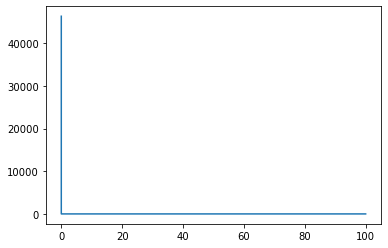

In [14]:
mu_scale_range = np.logspace(-5, 2, 50)
# mu_scale_range = np.linspace(1e-8, 1, 1000)
results = []
for mu_scale in mu_scale_range:
    results += [np.linalg.norm(project_on_data_span(mu * mu_scale, Q) - project_on_data_simplex(mu * mu_scale, Q))/(mu_scale)]
plt.plot(mu_scale_range, results)

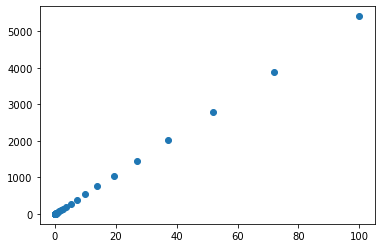

In [17]:
plt.plot(mu_scale_range, np.array(results) * mu_scale_range, 'o')

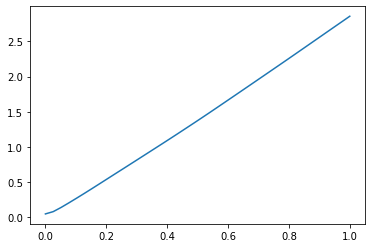

In [30]:
n = 100
p = 3000
mu = np.random.randn(p)
results = []
Sigma = np.ones(p)
Sigma = 1 / np.arange(1, p + 1)
Q =  np.random.randn(n, p) *  np.sqrt(Sigma)

A = Q @ Q.T
mu_inner_coord = np.linalg.pinv(Q).T @ mu

mu_scale_range = np.linspace(1e-8, 1, 40)
results = []
for mu_scale in mu_scale_range:
    proj_on_span = project_on_data_span(mu * mu_scale, Q)
#     proj_on_hull = project_on_data_simplex(mu * mu_scale, Q)
    proj_on_hull = Q.T @ project_on_data_simplex_preprocessed(mu_inner_coord * mu_scale, A)

    results += [np.linalg.norm((proj_on_span - proj_on_hull) * np.sqrt(Sigma))]
plt.plot(mu_scale_range, results)

# Measuring all the relevant quantities

The following vectors are of interest: $\mu_\perp$, projection of zero on the affine hull of the data, projection of zero on the simplex, $\mu$ itself, empirical mean. We need to measure their scalar products with $\mu$ and norms in $\Sigma$.

In [19]:
n = 100
p = 3000

In [20]:
Sigma = 1 / np.arange(1, p + 1)
Q =  np.random.randn(n, p) *  np.sqrt(Sigma)
mu = np.random.randn(p) * Sigma**1
# mu = np.eye(p)[3 * n]
y = np.ones(n)

A = Q @ Q.T
Q_pinv = np.linalg.pinv(Q)
A_inv = np.linalg.inv(A)

opt_estimator = mu / Sigma

mu_parallel_coord_in_Q = Q_pinv.T @ mu
mu_parallel = Q.T @ mu_parallel_coord_in_Q
mu_perp = mu - mu_parallel

mni_null = Q_pinv @ y
mni_null_norm = np.linalg.norm(mni_null)
mni_null_dir_unit_norm = mni_null / mni_null_norm
mni_null_dir_in_span = mni_null / mni_null_norm**2

mni_mu_parallel =  mni_null_dir_in_span + mni_null_dir_unit_norm * (mu @ mni_null_dir_unit_norm)

emp_mean = mu + Q.T @ y / n

def find_max_margin_pt_in_simplex(mu_parallel_coord_in_Q, A):
    n = len(mu_parallel_coord_in_Q)
    barycentric_coords = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(mu_parallel_coord_in_Q + barycentric_coords, A))
    constraints = [barycentric_coords >= 0, cp.sum(barycentric_coords) == 1]
    result = cp.Problem(objective, constraints).solve()
    return barycentric_coords.value

max_margin_minus_mni = mu_parallel + Q.T @ find_max_margin_pt_in_simplex(mu_parallel_coord_in_Q, A) - mni_mu_parallel


norm_in_sigma = lambda x: np.linalg.norm(x * np.sqrt(Sigma)) 
total = np.zeros(p)
print('<mu, x>   ||x||_s  ||tot||_s tot_perf')
for x in [mu_perp, mni_mu_parallel, max_margin_minus_mni, mu]:
    total += x
    print("%8.2f" % (x @ mu),
          "%8.2f" % (norm_in_sigma(x)),
          "%8.2f" % (norm_in_sigma(total)), 
          "%8.2f" % (total @ mu / norm_in_sigma(total))
         )
print(mu @ mu / norm_in_sigma(mu))
print(opt_estimator @ mu / norm_in_sigma(opt_estimator))

<mu, x>   ||x||_s  ||tot||_s tot_perf
    0.18     0.08     0.08     2.12
   -0.01     0.02     0.08     2.17
    0.08     0.05     0.12     2.11
    1.02     0.75     0.84     1.51
1.364481688711421
2.96997549812161


In [21]:
def cos_similarity_in_Sigma(x, y):
    return (x * Sigma) @ y /norm_in_sigma(x) / norm_in_sigma(y)

In [22]:
cos_similarity_in_Sigma(mu_perp, max_margin_minus_mni)

0.7742411435074994

In [23]:
total = 0.
for _ in range(100):
    mu = np.random.randn(p) * Sigma**3
    mu = np.eye(p)[0]
    mu_parallel_coord_in_Q = Q_pinv.T @ mu
    mu_parallel = Q.T @ mu_parallel_coord_in_Q
    mu_perp = mu - mu_parallel
    total += cos_similarity_in_Sigma(mu_perp, mu_parallel)
total/100

0.8808078293023178

In [24]:
np.arccos(0.88)/np.pi * 180

28.35763657632798

In [25]:
mu = np.random.randn(p) * Sigma**2
mu /= np.linalg.norm(mu)
mu_parallel_coord_in_Q = Q_pinv.T @ mu
mu_parallel = Q.T @ mu_parallel_coord_in_Q
mu_perp = mu - mu_parallel
total += cos_similarity_in_Sigma(mu_perp, mu_parallel)
print(mu_perp @ mu, mu_parallel @ mu)
print(norm_in_sigma(mu_perp),  norm_in_sigma(mu_parallel))
print(cos_similarity_in_Sigma(mu_perp, mu_parallel))

0.03971438862388351 0.9602856113761167
0.04441577175311765 0.9580296327992105
0.8653725497800533


In [2]:
def cos_similarity(x, y):
    return x @ y / np.linalg.norm(x) / np.linalg.norm(y)

In [52]:
p = 3000
mu_raw = np.random.randn(p)
Z = np.random.randn(n, p) 

In [94]:
Sigma = 1/np.arange(1, p+1)**0.5
k = 10
Sigma = np.ones(p)
Sigma[:k] *= (k + 2 - np.arange(1, k+1))**0 * 100

Q = Z * np.sqrt(Sigma)

In [95]:
cos_similarity(Sigma[:k], 1/Sigma[:k])

1.0

In [96]:
gamma_range = np.linspace(-1, 3, 2)
mu_perp_perfs = []
mu_parallel_perfs = []
mu_perfs = []
for gamma in gamma_range:
#     mu = mu_raw * Sigma**gamma
#     mu = np.copy(mu_raw)
    mu = np.ones(p)
    mu[k:] *= 10
    worst_case_weighting = np.sqrt(Sigma[:k]/np.linalg.norm(Sigma[:k]) + 1/Sigma[:k]/np.linalg.norm(1/Sigma[:k]))
    mu[:k] *= worst_case_weighting
    mu /= np.sqrt(mu @ (mu/Sigma))
    evaluate_perf = lambda x: mu @ x / np.linalg.norm(x * Sigma**0.5)
    mu_parallel_coord_in_Q = np.linalg.pinv(Q).T @ mu
    mu_parallel = Q.T @ mu_parallel_coord_in_Q
    mu_perp = mu - mu_parallel
    
    mu_perp_perfs += [evaluate_perf(mu_perp)]
    mu_parallel_perfs += [evaluate_perf(mu_parallel)]
    mu_perfs += [evaluate_perf(mu)]
    
    

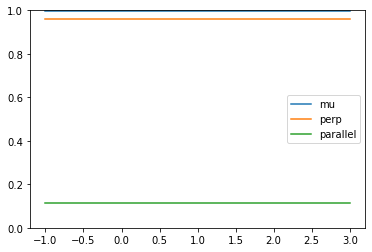

In [97]:
results = {
    'mu': mu_perfs,
    'perp': mu_perp_perfs,
    'parallel': mu_parallel_perfs
}
for name in results:
    plt.plot(gamma_range, (results[name]), label=name)
plt.ylim(0,1)
plt.legend()

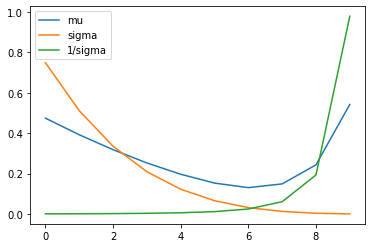

In [91]:
plt.plot(mu[:k]/np.linalg.norm(mu[:k]), label='mu')
plt.plot(Sigma[:k]/np.linalg.norm(Sigma[:k]), label='sigma')
plt.plot(1/Sigma[:k]/np.linalg.norm(1/Sigma[:k]), label='1/sigma')
plt.legend()

In [293]:
print(
    mu[:k], '\n',
    mu_perp[:k], '\n', 
    mu_parallel[:k]
)

[-0.34236045 -0.14592998  0.23669254 -0.36175655 -0.41460408 -0.8087918
  0.47463787 -1.39315727  0.42612961  0.6931726 ] 
 [-0.29200224 -0.05209128  0.1975418  -0.28812934 -0.33828798 -0.68680122
  0.44229982 -1.25360254  0.38419787  0.64000167] 
 [-0.05035821 -0.0938387   0.03915074 -0.07362721 -0.0763161  -0.12199057
  0.03233806 -0.13955473  0.04193174  0.05317093]


# Comparing mu and mu_perp

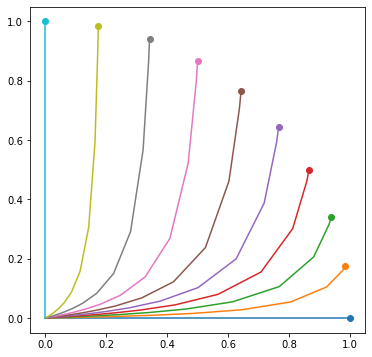

In [18]:
plt.figure(figsize=(6, 6))
dim = 2
gamma_range = np.linspace(0, 20, 100)**3
sigma = np.array([1, 0.1])
for phi in np.linspace(0, np.pi/2, 10):
    
    w_star = np.array([np.cos(phi), np.sin(phi)])
    plt.scatter(w_star[0], w_star[1])
#     print(w_star)
    mu = w_star * np.sqrt(sigma)
    x_coords = []
    y_coords = []
    for gamma in gamma_range:
        mu_perp_gamma =  w_star/(gamma/sigma + 1)
        x_coords += [mu_perp_gamma[0]]
        y_coords += [mu_perp_gamma[1]]
    plt.plot(x_coords, y_coords)

# plt.xlim(0, 1)
# plt.ylim(0, 1)